In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir("..")
import src.models as models
import src.utils as utils
import src.main as main
from tqdm import tqdm

%load_ext autoreload
%autoreload 

logger = utils.setup_logger(__name__)
logger(".")

2024-08-27 18:34:55 | .


---

#### Settings

In [2]:
class Settings:
    num = 100
    load = True
    idx = 0
    use_bias = False
    
args = Settings()

if args.load:
    info, autoencoder = models.load_session(idx=args.idx)
    dim_ei = info["dim_ei"]
    dim_ca3 = info["dim_ca3"]
    dim_ca1 = info["dim_ca1"]
    dim_eo = info["dim_eo"]

    num_samples = info["num_samples"]

    K_lat = info["K_lat"]
    beta = info["beta"]
    K = info["K"]

    logger("<<< Loaded session >>>")
else:
    dim_ei = 50
    dim_ca3 = 50 
    dim_ca1 = 50
    dim_eo = dim_ei

    # data settings
    num_samples = 300

    # model hyper-parameters
    K = 5
    K_lat = 15
    beta = 60

    # autoencoder
    autoencoder = Autoencoder(input_dim=dim_ei,
                              encoding_dim=dim_ca1,
                              activation=None,
                              K=K_lat,
                              beta=beta,
                              use_bias=args.use_bias)
    logger(f"%Autoencoder: {autoencoder}")

2024-08-27 18:34:55 | Saved sessions:
2024-08-27 18:34:55 | Pre-selected session: [0]
/Users/daniekru/Research/lab/KAMemory/src/models.py:403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experime

[0] ae_20_1341
[1] ae_3
[2] ae_19_1731
[3] ae_20_1332
{'K': 5,
 'K_lat': 15,
 'beta': 60,
 'dim_ca1': 50,
 'dim_ca3': 50,
 'dim_ei': 50,
 'dim_eo': 50,
 'epochs': 500,
 'loss_ae': 0.05726,
 'num_reconstructions': 1,
 'num_samples': 10000}


#### Dataset

In [3]:
training_samples = utils.sparse_stimulus_generator(N=num_samples,
                                                   K=K,
                                                   size=dim_ei,
                                                   plot=False)
test_samples = utils.sparse_stimulus_generator(N=num_samples,
                                               K=K,
                                               size=dim_ei,
                                               plot=False)

# dataset for btsp
num_btsp_samples = args.num
training_sample_btsp = training_samples[np.random.choice(
                        range(training_samples.shape[0]),
                        num_btsp_samples, replace=False)]


logger("<<< Data generated >>>")

2024-08-27 18:34:56 | <<< Data generated >>>


2024-08-27 18:34:56 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5
/Users/daniekru/Research/lab/KAMemory/src/utils.py:399: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:k+1], dtype=torch.float32).detach()


0 tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
0 0


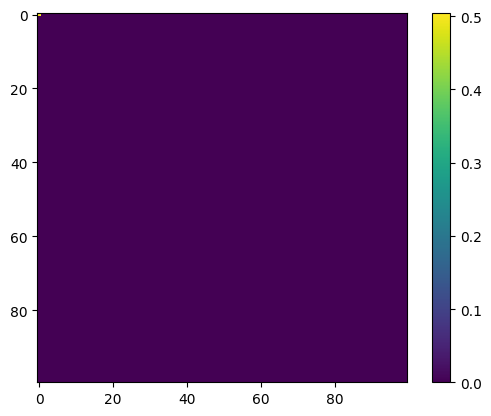

In [4]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

In [5]:
training_sample_btsp.shape

(100, 50)

#### **AE** training

In [6]:
# train autoencoder
if not args.load:
    epochs = 400
    loss_ae, autoencoder = utils.train_autoencoder(
                    training_data=training_samples,
                    test_data=test_samples,
                    model=autoencoder,
                    epochs=int(epochs),
                    batch_size=10, learning_rate=1e-3)
    logger(f"<<< Autoencoder trained [loss={loss_ae:.4f}] >>>")

# reconstruct data
out_ae, latent_ae = utils.reconstruct_data(data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=autoencoder,
                                show=False, 
                                plot=False)

100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 9353.73it/s]


#### **MTL** training

In [6]:
W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)

#### attempt 1

2024-08-27 18:16:51 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5
100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 6744.88it/s]


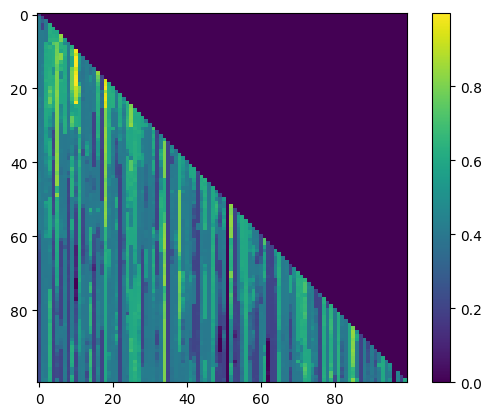

In [4]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1, B_ca1_eo = None, None
    

#logger.debug(f"{W_ei_ca1.shape=}\n{type(W_ei_ca1)}")

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    loss_mtl, _, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=True,
                                progressive_test=True)
    #logger(f"<<< MTL trained [{loss_mtl:.3f}] >>>")

# reconstruct data
model.pause_lr()
out_mtl, latent_mtl = utils.reconstruct_data(
                                data=training_sample_btsp,
                                num=num_btsp_samples,
                                model=model,
                                column=True,
                                plot=False)

plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

#### attempt 2

2024-08-27 18:17:02 | %MTL: MTL(dim_ei=50, dim_ca1=50, dim_ca3=50, dim_eo=50,  bias=False, lr=1.0,beta=60, alpha=0.01, K_l=15, K_o=5


torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 50])


/Users/daniekru/Research/lab/KAMemory/src/utils.py:423: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data[:k+1], dtype=torch.float32).detach()


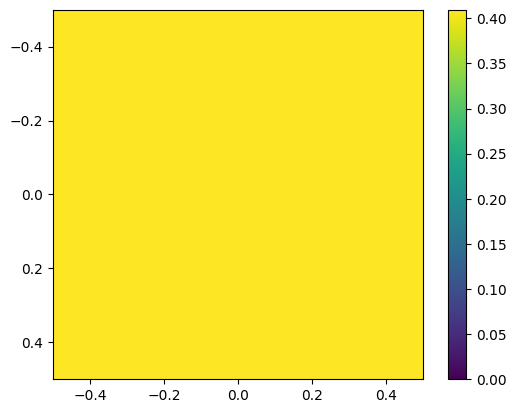

In [5]:
""" mtl training """

# get weights from the autoencoder
if args.use_bias:
    W_ei_ca1, W_ca1_eo, B_ei_ca1, B_ca1_eo = autoencoder.get_weights(bias=True)
else:
    W_ei_ca1, W_ca1_eo = autoencoder.get_weights(bias=False)
    B_ei_ca1 = None
    B_ca1_eo = None

# make model
model = models.MTL(W_ei_ca1=W_ei_ca1,
            W_ca1_eo=W_ca1_eo,
            B_ei_ca1=B_ei_ca1,
            B_ca1_eo=B_ca1_eo,
            dim_ca3=dim_ca3,
            lr=1.,
            K_lat=K_lat,
            K_out=K,
            beta=beta)

logger(f"%MTL: {model}")

# train model | testing = training without backprop
epochs = 1
for _ in range(epochs):
   # _, model = utils.testing(data=training_sample_btsp,
   #                                 model=model,
   #                                 column=True)

    #model.pause_lr()
    acc, _, = utils.progressive_testing(data=training_sample_btsp,
                                model=model)

plt.imshow(acc, vmin=0)
plt.colorbar();

In [9]:
acc.shape

torch.Size([1, 1])

100%|██████████████████████████████████████████████| 10/10 [00:10<00:00,  1.04s/it]


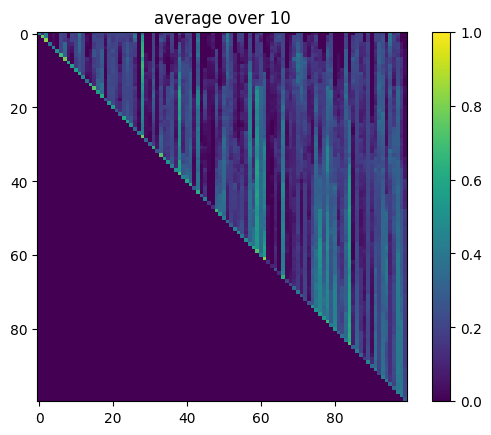

In [28]:
NUM_REP = 10

acc = np.zeros((args.num, args.num))
for _ in tqdm(range(NUM_REP)):
    model = models.MTL(W_ei_ca1=W_ei_ca1,
                W_ca1_eo=W_ca1_eo,
                B_ei_ca1=B_ei_ca1,
                B_ca1_eo=B_ca1_eo,
                dim_ca3=dim_ca3,
                lr=1.,
                K_lat=K_lat,
                K_out=K,
                beta=beta)
    
    #logger(f"%MTL: {model}")
    
    # train model | testing = training without backprop
    acc_epoch, _, _ = utils.testing(data=training_sample_btsp,
                                model=model,
                                column=True,
                                use_tensor=False,
                                progressive_test=True)

    acc += acc_epoch.numpy()
    
acc /= NUM_REP
plt.imshow(acc, vmin=0, vmax=1)
plt.title(f"average over {NUM_REP}")
plt.colorbar();

## Plotting

In [ ]:
### """ plotting """

# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 5), sharex=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax1,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=latent_ae, ax=ax2,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=latent_mtl, ax=ax3,
                         title="MTL", squash=is_squash)

fig.suptitle(f"Latent layers - $K_l=${K_lat} $\\beta=${autoencoder._beta}")

#
fig2, (ax12, ax22, ax32) = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
is_squash = False

utils.plot_squashed_data(
    data=training_sample_btsp,
                         ax=ax12,
                         title="Patterns", squash=is_squash)
utils.plot_squashed_data(data=out_ae, ax=ax22,
                         title="Autoencoder",
                         squash=is_squash)
utils.plot_squashed_data(data=out_mtl, ax=ax32,
                         title="MTL",
                         squash=is_squash)

fig2.suptitle(f"Data reconstruction of {num_btsp_samples} patterns - $K=${K} $\\beta=${autoencoder._beta}",
              fontsize=15)

#
fig3, (ax13) = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
cbar = plt.colorbar(
    ax13.imshow(training_sample_btsp - out_mtl,
                cmap="seismic",
                aspect="auto"))
ax13.set_yticks(range(num_btsp_samples))

cbar.set_label("Error")
ax13.set_title("pattern - mtl")
plt.show()



In [ ]:
plt.imshow(loss_mtl, vmin=0)
plt.colorbar();

In [ ]:
dd